In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config
import pickle


Terrain Vegetation has the following properties for linear and angular tractions.
mean=(0.29, 0.29), std=(0.36, 0.36), cvar(0.30)=(0.01, 0.01) (computed from 10000.0 saved samples)
Terrain Dirt has the following properties for linear and angular tractions.
mean=(0.65, 0.65), std=(0.10, 0.10), cvar(0.30)=(0.53, 0.53) (computed from 10000.0 saved samples)
1.0
0.9999999999999997
1.0000000000000004
1.0000000000000002


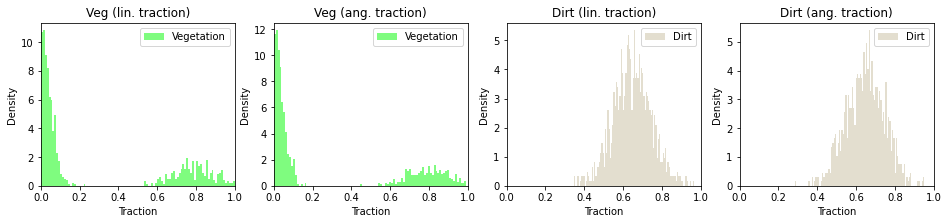

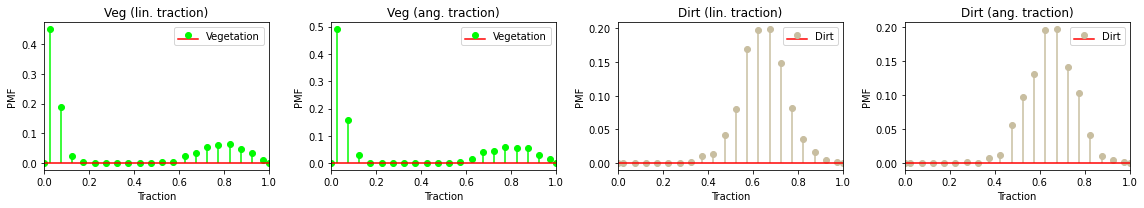

In [2]:
# What percentile of the speed distribution to compute conditional expectation?
cvar_alpha =0.3

# pmf_bounds = [0, 1.0]
# bush_weights = [0.6, 0.4]
# bush_means= [0, 0.8]
# bush_std = [0.15, 0.1]
pmf_bounds = [0, 1.0]
bush_weights = [0.8, 0.2]
bush_means= [0, 0.8]
bush_std = [0.05, 0.1]
dirt_weights = [1]
dirt_means = [0.65]
dirt_std = [0.1]
# dirt_weights = [1]
# dirt_means = [1]
# dirt_std = [0.001]
bush_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
bush_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
dirt_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)
dirt_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)

bush = Terrain(name='Vegetation', lin_density=bush_lin_gm, ang_density=bush_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((0,250,0))/255.0)
dirt = Terrain(name='Dirt', lin_density=dirt_lin_gm, ang_density=dirt_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((200,190,160))/255.0)
print(bush)
print(dirt)

ID2NAME = {
    0: dirt.name,
    1: bush.name
}
NAME2TERRAIN = {
    bush.name: bush,
    dirt.name: dirt
}

num_bins=20
b_lin_values, b_lin_pmf = bush_lin_gm.get_pmf(num_bins=num_bins)
b_ang_values, b_ang_pmf = bush_ang_gm.get_pmf(num_bins=num_bins)
d_lin_values, d_lin_pmf = dirt_lin_gm.get_pmf(num_bins=num_bins)
d_ang_values, d_ang_pmf = dirt_ang_gm.get_pmf(num_bins=num_bins)
print(np.sum(b_lin_pmf))
print(np.sum(b_ang_pmf))
print(np.sum(d_lin_pmf))
print(np.sum(d_ang_pmf))



LIN_TERRAIN2PMG = {
    bush: (b_lin_values, b_lin_pmf),
    dirt: (d_lin_values, d_lin_pmf),
}
ANG_TERRAIN2PMG = {
    bush: (b_ang_values, b_ang_pmf),
    dirt: (d_ang_values, d_ang_pmf),
}
# -------------- Visualize the speed distribution for each class---------
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density(axes[0], bush_lin_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (lin. traction)", color=bush.rgb)
vis_density(axes[1], bush_ang_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (ang. traction)", color=bush.rgb)
vis_density(axes[2], dirt_lin_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density(axes[3], dirt_ang_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (ang. traction)", color=dirt.rgb)

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density_as_pmf(axes[0], bush_lin_gm, bush, num_bins=num_bins, title="Veg (lin. traction)", color=bush.rgb)
vis_density_as_pmf(axes[1], bush_ang_gm, bush, num_bins=num_bins, title="Veg (ang. traction)", color=bush.rgb)
vis_density_as_pmf(axes[2], dirt_lin_gm, dirt, num_bins=num_bins, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density_as_pmf(axes[3], dirt_ang_gm, dirt, num_bins=num_bins, title="Dirt (ang. traction)", color=dirt.rgb)

plt.tight_layout()
plt.show()

TDM has initialized GPU memory after 0.3983426094055176 s
TDM has initialized GPU memory after 0.041561126708984375 s
MPPI planner has initialized GPU memory after 0.016312360763549805 s


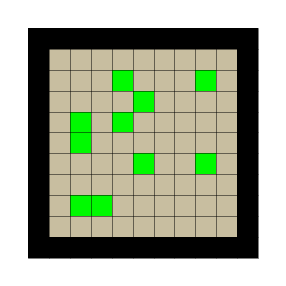

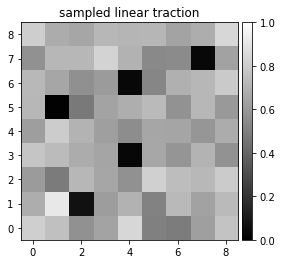

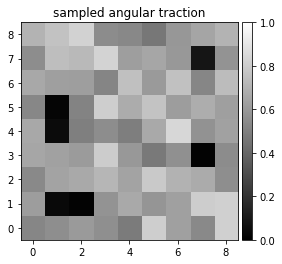

In [3]:
# ------------- Create and visualize the map ------------
# Fixed a sampled environment
grid_shape = (9, 9)
# grid_shape = (100, 100)
mud_margin = 1
res = 1.0
# res = 0.1
semantic_grid = np.zeros(grid_shape, dtype=np.int8)
rand_num = np.random.rand(grid_shape[0]-2*mud_margin, grid_shape[1]-2*mud_margin)
perc_grass = 0.2
# perc_grass = 0.8
semantic_grid[mud_margin:-mud_margin, mud_margin:-mud_margin][rand_num<perc_grass] = 1


xlimits = (0,semantic_grid.shape[1]*res)
ylimits = (0,semantic_grid.shape[0]*res)
num_pmf_bins = len(d_ang_pmf) # Assume numbers of bins are the same for linear and angular components for now
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))
max_speed = 3.0

use_tdm = True
use_det_dynamics = False # True
use_nom_dynamics_with_speed_map = False
use_costmap = False

# ------ General configs for both MPPI and TDM ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024,
  num_control_rollouts = 1024,
  max_speed_padding = max_speed+2.0,
  num_vis_state_rollouts = 50,
  max_map_dim =(15, 15),
  # max_map_dim =(120, 120),
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)

# ------------- Problem configuration ------------
x0=np.array([mud_margin/2, mud_margin/2, np.pi/4])
xgoal= np.array([grid_shape[0]-mud_margin/2, grid_shape[0]-mud_margin/2])

mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,

    # For risk-aware min time planning
    goal_tolerance=0.5,
    v_post_rollout=0.01,
    cvar_alpha=0.5, # use the mean if cvar_alpha=1.0

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    # u_std=np.array([3.0, 3.0]), # angular part affects how much robot turns to squeeze through gaps
    u_std=np.array([3.0, 3.0]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([-0.5, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),
)

# ------------- Configure the TDM based on whether determinisitc dynamics are used ------------
lin_tdm = TDM_Numba(cfg)
ang_tdm = TDM_Numba(cfg)
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                                  xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                                  mppi_params['cvar_alpha'])
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                                  xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                                  mppi_params['cvar_alpha'])


lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5))


mppi_planner = MPPI_Numba(cfg)



# Sample a specific map from the distribution that can be used to update the robot state
traction_grid = lin_tdm.sample_grids_true_dist()
fig, ax = plt.subplots()
lin = traction_grid.lin_traction
img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
ax.set_title('sampled linear traction')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img, cax=cax)
plt.show()

fig, ax = plt.subplots()
ang = traction_grid.ang_traction
img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
ax.set_title('sampled angular traction')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img, cax=cax)
plt.show()



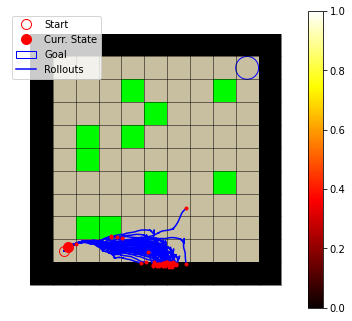

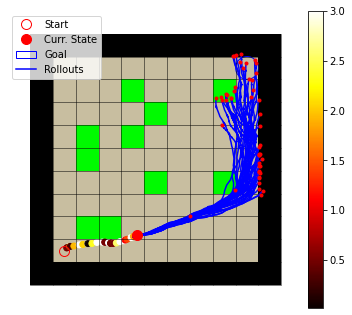

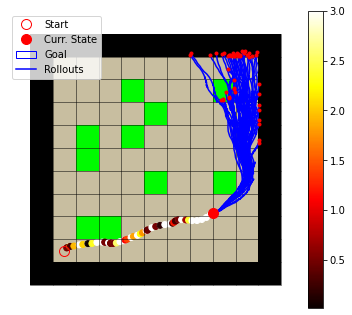

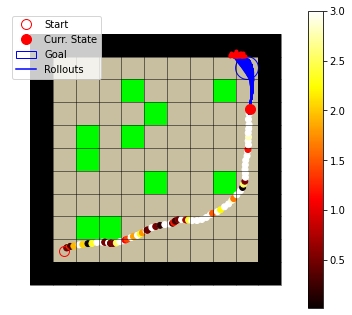

goal reached at t=98


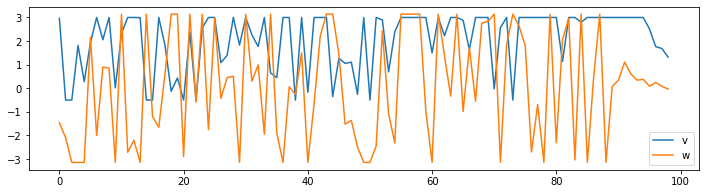

In [10]:
# mppi_params['cvar_alpha']=0.1
# mppi_params['v_post_rollout']=0.1


# Construct the MPPI planner + initialize the GPU variables
lin_tdm.reset()
ang_tdm.reset()
mppi_planner.reset()
# obstacle_map = np.zeros(semantic_grid.shape, dtype=np.int8)
# obstacle_map[3:5, :-2] = 1
# unknown_map = np.zeros(semantic_grid.shape, dtype=np.int8)
# unknown_map[:-5, 3:5] = 1
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                    mppi_params['cvar_alpha'], obstacle_map=obstacle_map, unknown_map=unknown_map)
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                    mppi_params['cvar_alpha'], obstacle_map=obstacle_map, unknown_map=unknown_map)
mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)

# If want to assess the run time
# mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)
# %timeit mppi_planner.solve()


# Loop
max_steps = 151
# max_steps = 1
xhist = np.zeros((max_steps+1, 3))*np.nan
uhist = np.zeros((max_steps, 2))*np.nan
xhist[0] = x0

plot_every_n = 30
# plot_every_n = 1
for t in range(max_steps):
  # Solve
  useq = mppi_planner.solve()
  u_curr = useq[0]
  uhist[t] = u_curr

  # Simulate state forward using the sampled map
  lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
  xhist[t+1, 0] = xhist[t, 0] + cfg.dt*lt*np.cos(xhist[t, 2])*u_curr[0]
  xhist[t+1, 1] = xhist[t, 1] + cfg.dt*lt*np.sin(xhist[t, 2])*u_curr[0]
  xhist[t+1, 2] = xhist[t, 2] + cfg.dt*at*u_curr[1]


  if t%plot_every_n==0:
    # Visualize the basic set up
    lin_tdm_vis = TDM_Visualizer(lin_tdm)
    fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
    ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
    ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'ro', markersize=10, label="Curr. State", zorder=5)
    c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal")
    ax.add_patch(c1)

    # Get rollout states from subset of maps for visualization? (e.g., 50)
    rollout_states_vis = mppi_planner.get_state_rollout()
    
    # ax.plot(xhist[:,0], xhist[:,1], 'r', label="Past State")
    # sc = ax.scatter(xhist[1:t+1,0], xhist[1:t+1,1], c=np.linalg.norm(uhist[:t], axis=1), cmap='hot')
    sc = ax.scatter(xhist[1:t+1,0], xhist[1:t+1,1], c=np.abs(uhist[:t, 0]), cmap='hot')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(sc, cax=cax)
    
    ax.plot(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T, 'r.', zorder=4)
    ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b', zorder=3)
    ax.plot(rollout_states_vis[0,:,0], rollout_states_vis[0,:,1], 'b', label="Rollouts")
    ax.legend()
    plt.tight_layout()
    plt.show()
  
  # Update MPPI state (x0, useq)
  mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

  
  # Goal check
  if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
    print("goal reached at t={}".format(t))
    break



fig, ax = plt.subplots(figsize=(12,3))
ax.plot(uhist[:,0], label='v')
ax.plot(uhist[:,1], label='w')
ax.legend()
plt.show()

In [11]:
# print(unknown_map)

In [5]:
# print(mppi_planner.lin_tdm.sample_grid_batch_d.copy_to_host())
# print(mppi_planner.ang_tdm.sample_grid_batch_d.copy_to_host())
# print(mppi_planner.lin_tdm.risk_traction_map_d.copy_to_host().shape)
# print(mppi_planner.lin_tdm.risk_traction_map_d.copy_to_host())
# print(mppi_planner.lin_tdm.obstacle_map_d.copy_to_host())

In [10]:
# %%timeit
# # lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
# #                     xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
# #                     mppi_params['cvar_alpha'])
# # ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
# #                     xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
# #                     mppi_params['cvar_alpha'])
# mppi_planner.reset()
# mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)
# mppi_planner.solve()

53.5 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Test CVaR related approximations using PMF representation

In [ ]:
import numpy as np
pmf = np.random.rand(4, 3, 5)
pmf /= pmf.sum(axis=0)

In [ ]:
pmf

In [ ]:
pmf.cumsum(axis=0)>=0.5

In [ ]:
which_layer = np.argmax(pmf.cumsum(axis=0)>=0.5, axis=0)
print(which_layer)
l, num_rows, num_cols = pmf.shape
output = np.zeros_like(pmf)
output[which_layer.ravel(), np.repeat(np.arange(num_rows), num_cols), np.tile(np.arange(num_cols), num_rows)] = 100
print(output)
assert (np.sum(output, axis=0)==(np.ones((num_rows, num_cols))*100)).all()

In [ ]:
1.1//0.5

In [ ]:
-0.1//0.05

Check whether two ranges overlap

In [ ]:
def check_overlap(r1, r2):
  bounds = None
  start_in_r1 = None
  overlapping = r1[0]<=r2[1] and r2[0]<=r1[1]
  if overlapping:
    amount_overlap = min(r1[1], r2[1]) - max(r1[0], r2[0])
    if amount_overlap>=0:
      start_in_r1 = np.argmax([r1[0], r2[0]])==0
      start = r1[0] if start_in_r1 else r2[0]
      bounds = [start, start+amount_overlap]
      
  return overlapping, bounds, start_in_r1

def ranges_overlap(r1, r2):
  return r1[0]<=r2[1] and r2[0]<=r1[1]

def maps_overlap(xlim1, ylim1, xlim2, ylim2):
  return ranges_overlap(xlim1, xlim2) and ranges_overlap(ylim1, ylim2)

r1 = [-7.0, -4.9999]
r2 = [-5,1.1]
overlapping, bounds, start_in_r1 = check_overlap(r1, r2)
if overlapping:
  print("Overlap is {}, starting in {}".format(bounds, 'r1' if start_in_r1 else 'r2'))
else:
  print("No overlap")

xlim1 = [0,10]
ylim1 = [0,10]
xlim2 = [5,10]
ylim2 = [-5,11]
print(maps_overlap(xlim1, ylim1, xlim2, ylim2))


In [ ]:
np.argmax([1,2])

### Test CVaR related approximations using risk_traction_map
Represent CVaR traction values between traction_min and traction_max using integer values between 0 and 100 

In [ ]:
import numpy as np

pmf = np.random.rand(4, 3, 5)
pmf[0,:,:] = 0
pmf /= pmf.sum(axis=0)
print(pmf)

In [ ]:
bin_values_bounds = np.asarray([0.0, 1.0])
bin_values = np.asarray([0.0, 0.3, 0.7,1.0])
traction_range = bin_values_bounds[1]-bin_values_bounds[0]
cvar_alpha=0.0001

weighted_values = pmf*bin_values.reshape((-1,1,1))
weighted_values_cumsum = np.cumsum(weighted_values, axis=0)
pmf_cumsum = pmf.cumsum(axis=0)
if cvar_alpha==1.0:
  which_layer = np.ones(pmf.shape[1:], dtype=int)*(pmf.shape[0]-1)
else:
  which_layer = np.argmax(pmf_cumsum>=cvar_alpha, axis=0)
print(pmf_cumsum)
print(which_layer)
# print(weighted_values_cumsum)

_, num_rows, num_cols = pmf.shape
l_indices = which_layer.ravel()
r_indices = np.repeat(np.arange(num_rows), num_cols)
c_indices = np.tile(np.arange(num_cols), num_rows)
v = weighted_values_cumsum[l_indices, r_indices, c_indices] / pmf_cumsum[l_indices, r_indices, c_indices].ravel()
print(v.reshape(num_rows, num_cols))



In [ ]:
a = np.random.randint(0,10, (10,10))
print(a)

In [ ]:
temp = np.zeros((2, 10,10))
# temp[:,a==7] = np.array([1,2]).reshape(2,1)
temp[:,a==7] = np.reshape([2,3], (2,1))
print(temp)

In [ ]:
np.argwhere(np.random.rand(3,3)>0.5)

In [ ]:
means = np.random.rand(3,3)
means = np.ones((3,3))
bin_values = np.array([0.0,0.1,0.4,0.8,1.0])

In [ ]:
print(means)
np.argmax(means <= bin_values.reshape((-1, 1, 1)), axis=0)

In [ ]:
np.ones((3,3),dtype=int).astype(float)